In [12]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import matplotlib.pyplot as plt

## 1 生成数据集并展示

In [13]:
n_train, n_test, num_inputs = 7000, 3000, 500
true_w, true_b = torch.ones(num_inputs, 1) * 0.0056, 0.028

features = torch.randn((n_train + n_test, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

## 2 读取数据

In [14]:
batch_size = 64
train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_features, test_labels)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,  num_workers=0)

In [15]:
for X, y in train_iter:
    print(X, y)
    break

tensor([[-0.4784, -0.0643,  0.1850,  ..., -0.3743, -0.2873, -0.6141],
        [-1.2060,  1.7336, -0.2345,  ...,  0.6280, -1.2142,  0.9245],
        [-0.5445,  0.4253, -0.5500,  ...,  0.2221, -0.0189, -0.5654],
        ...,
        [ 0.1510, -0.6479,  0.5433,  ..., -0.0135,  0.8686,  0.8168],
        [ 0.9448, -0.2648, -0.6658,  ...,  0.2800,  1.2782,  0.1770],
        [-0.9922,  1.1037, -0.8067,  ...,  1.5691, -0.0671,  1.2015]]) tensor([[-0.0004],
        [ 0.1492],
        [ 0.1821],
        [-0.0329],
        [ 0.0195],
        [-0.0232],
        [ 0.0336],
        [ 0.0379],
        [-0.0242],
        [-0.0638],
        [ 0.0255],
        [ 0.1435],
        [ 0.0856],
        [ 0.0861],
        [ 0.2189],
        [ 0.0014],
        [-0.0674],
        [-0.2332],
        [-0.3835],
        [ 0.0748],
        [-0.0269],
        [ 0.1422],
        [ 0.0128],
        [-0.0391],
        [-0.0131],
        [-0.0449],
        [-0.0300],
        [-0.0143],
        [ 0.2120],
        [-0.181

## 4 定义模型

In [16]:
num_inputs, num_outputs, num_hiddens = 500, 1, 200

net = nn.Sequential(
    nn.Linear(num_inputs, num_hiddens),
    #nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs),
)
#初始化参数
for params in net.parameters():
    init.normal_(params, mean=0, std=0.01)

## 5 定义损失函数

In [17]:
def squared_loss(y_hat, y):
    return (y_hat - y.view(y_hat.size())) ** 2 / 2
loss = nn.L1Loss()

## 6 定义优化算法

In [18]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

## 7 定义loss画图函数

In [19]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, legend=None, figsize=(3.5, 2.5)):
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

## 8 训练模型

In [20]:
def train(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, optimizer=None):
    train_ls, test_ls = [], []
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum() # + lambd * l2_penalty(W1) + lambd * l2_penalty(W2)
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            # 反向传播 + 更新优化参数
            l.backward()
            if optimizer == None:
                SGD(params, lr)
            else:
                optimizer.step()
        
        train_acc, train_l = evaluate_accuracy(train_iter, net, loss)
        test_acc, test_l = evaluate_accuracy(test_iter, net, loss)
        train_ls.append(train_l)
        test_ls.append(test_l)
        print('epoch %d, train loss %.4f, test_loss %.4f, train_acc %.3f, test_acc %.3f' % (epoch + 1, train_ls[-1], test_ls[-1], train_acc, test_acc))
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss', range(1, num_epochs + 1), test_ls, ['train', 'test'])
    return train_ls, test_ls

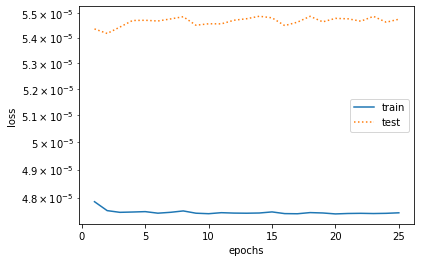

In [22]:
num_epochs = 25
train(net, train_iter, test_iter, squared_loss, num_epochs, batch_size, None, None, optimizer)